# PAINS

O termo PAINS foi apresentado em [um trabalho](https://pubs.acs.org/doi/10.1021/jm901137j) de 2010 por Baell e Holloway. É a sigla para *Pan Assay Interference Compounds*, compostos químicos que segundo os autores possuem propriedades que os tornam problemáticos na triagem em ensaios biológicos de alto rendimento (HTS, *high throughput screening*). 

Diversas propriedades de um composto químico poderiam levá-lo a ser considerado problemático.

Podemos pensar, por exemplo, em um composto com uma **alta reatividade** química não específica. Ele poderá apresentar uma alta atividade biológica contra inúmeros organismos por reagir com suas proteínas e DNA, mas, na prática, não serve como medicamento, pois sua alta reatividade também levará a problemas de toxicidade nos humanos.

Alguns compostos apresentam grupos funcionais que tendem a promover **agregação de proteínas**, diminuindo a atividade de enzimas sem, de fato, inibí-las. Portanto, esses compostos aparentam ser ativos em testes *in vitro*, mas falham *in vivo*.

Outros compostos, apesar de apresentarem atividade biológica *in vitro*, possuem **baixa biodisponibilidade**, por exemplo, por serem metabolizados rapidamente. Um exemplo clássico desse caso é a [curcumina](https://go.drugbank.com/drugs/DB11672).

Veja, portanto, que existem compostos químicos que, apesar de produzirem uma resposta de atividade elevada, não têm utilidade como fármacos. Em outras palavras, são compostos que levam a uma resposta do tipo "falso positivo". 

O termo PAINS se refere a uma classe de compostos que, de acordo com os autores, **interferem** no resultado de um ensaio, sem necessariamente apresentarem as propriedades descritas anteriormente. Os autores identificaral algumas **subestruturas** que seriam responsáveis por essa atividade pan-ensaio. Alguns exemplos são [aceptores de Michael](https://en.wikipedia.org/wiki/Michael_addition_reaction) e [rodaninas](https://en.wikipedia.org/wiki/Rhodanine). A lista completa de subestruturas está disponível [no material suplementar do artigo](https://pubs.acs.org/doi/suppl/10.1021/jm901137j/suppl_file/jm901137j_si_001.pdf) e também no [RDKit](https://github.com/rdkit/rdkit/blob/master/Data/Pains/wehi_pains.csv), já na forma de SMARTS.

Os autores sugeriram que incluir esses compostos "interferentes" em ensaios de alto rendimento representaria uma perda de tempo e recursos, sendo aconselhável nem mesmo incluí-los nas suas bibliotecas de compostos. Assim, as subestruturas PAINS  têm sido usado amplamente na literatura para filtragem de compostos. 

Contudo, o trabalho [não ficou livre de críticas](https://fbdd-lit.blogspot.com/2015/10/a-painful-convolution-of-fact-with.html). Em especial, foi destacado que o painel de seis ensaios usado é muito pequeno para caracterizar uma atividade "pan-ensaio". Além disso, cerca de 5% dos fármacos aprovados pelo FDA [apresentam subestruturas PAINS](https://pubs.acs.org/doi/10.1021/acschembio.7b00903).

# Funções

In [1]:
# PAINS filter - RDKit
# https://projects.volkamerlab.org/teachopencadd/talktorials/T003_compound_unwanted_substructures.html
# https://www.rdkit.org/docs/source/rdkit.Chem.rdfiltercatalog.html

import pandas as pd
from rdkit import Chem
from rdkit.Chem.FilterCatalog import FilterCatalog, FilterCatalogParams
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole

# Importar lista de SMARTS contendo os PAINS - vamos usar para destacar as subestruturas
pains_list = pd.read_csv("https://raw.githubusercontent.com/rdkit/rdkit/refs/heads/master/Data/Pains/wehi_pains.csv", header=None)
pains_list.columns = ["SMARTS", "ID"]

# Iniciar filtro
params = FilterCatalogParams()
params.AddCatalog(FilterCatalogParams.FilterCatalogs.PAINS)
catalog = FilterCatalog(params)

# Função simples que retorna True se alguma subestrutura PAINS é identificada
def pains_bool(mol):
    # Basta identificar uma subestrutura PAINS
    entry = catalog.GetFirstMatch(mol)
    return bool(entry)

# Função que retorna uma lista com todos os IDs dos PAINS identificados
def pains_enumerate(mol):
    mol = Chem.AddHs(mol)
    if pains_bool(mol):
        ID_list = []
        for index, row in pains_list.iterrows():
            smarts = row['SMARTS']
            ID = row['ID']
            match = mol.GetSubstructMatch(Chem.MolFromSmarts(smarts))
            if match:
                # Usei [7:-1] para limpar o ID e deixar apenas o nome da subestrutura e o número
                ID_list.append(ID[7:-1])
        return ID_list
    return []
    
def pains_highlight(mol):
    # Retorna a imagem da estrutura com os PAINS destacados
    # Alguns SMARTS podem produzir erros. Veja: https://github.com/rdkit/rdkit/issues/3912
    mol = Chem.AddHs(mol)
    if pains_bool(mol):
        match_list = []
        ID_list = []
        # Desenhar estruturas no grid destacando os PAINS
        for index, row in pains_list.iterrows():
            smarts = row['SMARTS']
            ID = row['ID']
            # https://www.rdkit.org/docs/source/rdkit.Chem.rdchem.html#rdkit.Chem.rdchem.Mol.GetSubstructMatch
            # Caso a estrutura tenha mais de uma subestrutura correspondente a PAINS, somente uma será destacada.
            match = mol.GetSubstructMatch(Chem.MolFromSmarts(smarts))
            if match:
                match_list.append(match)
                # Usei [7:-1] para limpar o ID e deixar apenas o nome da subestrutura e o número
                ID_list.append(ID[7:-1])
        ms = [mol] * len(match_list)
        img = Draw.MolsToGridImage(ms, 
                                   molsPerRow=2, 
                                   subImgSize=(400, 300), 
                                   highlightAtomLists=match_list,
                                   legends=ID_list)
        return img
    return

In [2]:
# Este é o arquivo do RDKit que contém os SMARTS dos PAINS e os identificadores
pains_list

,SMARTS,ID
0,c:1:c:c(:c:c:c:1-[#6;X4]-c:2:c:c:c(:c:c:2)-[#7...,<regId=anil_di_alk_F(14)>
1,c:1(:c(:c(:c(:c(:c:1-[#1])-[#1])-[#7](-[#1])-[...,<regId=hzone_anil(14)>
2,"c1(nn(c([c;!H0,$(c-[#6;!H0])]1)-[#8]-[#1])-c:2...",<regId=het_5_pyrazole_OH(14)>
3,"c:2(:c:1-[#16]-c:3:c(-[#7;!H0,$([#7]-[CH3]),$(...",<regId=het_thio_666_A(13)>
4,[#6]-2-[#6]-c:1:c(:c:c:c:c:1)-[#6](-c:3:c:c:c:...,<regId=styrene_A(13)>
...,...,...
475,c:1(:c:c:c(:c:c:1)-[#6]=[#7]-[#7])-[#8]-[#1],<regId=hzone_phenol_B(215)>
476,[#6]-1(=[#6])-[#6]=[#7]-[!#6&!#1]-[#6]-1=[#8],<regId=ene_five_het_A(201)>
477,c:1:c:c(:c:c:c:1-[#7](-[#6;X4])-[#6;X4])-[#6;X...,<regId=anil_di_alk_D(198)>
478,[#8]=[#6]-2-[#6](=!@[#7]-[#7])-c:1:c:c:c:c:c:1...,<regId=imine_one_isatin(189)>


# Exemplo

Vamos explorar o conjunto de dados de produtos naturais brasileiros, o [NuBBEDB](https://www.nature.com/articles/s41598-017-07451-x). Fiz o download da pasta contendo arquivos .`mol2` pelo [website do NUBBE](https://nubbe.iq.unesp.br/portal/nubbe-search.html). Converti os compostos a um arquivo `.smi`, que está disponível na pasta `datasets`.

In [3]:
df = pd.read_csv("../datasets/NuBBENP.smi", sep=" ", header=None)
df.columns = ["SMILES", "ZINC_Code"]
df.head()

,SMILES,ZINC_Code
0,C(C1(C([H])([H])[H])[C@@]2([H])C([H])([H])C([H...,NuBBE_1003_obabel_3D.mol2
1,C(C([C@@]([H])(/C(=C(/[C@]([H])([C@@]1([H])C([...,NuBBE_1004_obabel_3D.mol2
2,C(C([C@@]([H])(/C(=C(/[C@]([H])([C@@]1([H])C([...,NuBBE_1005_obabel_3D.mol2
3,O=C1c2c(O[H])c([H])c([H])c([H])c2[C@@]([H])(O[...,NuBBE_1006_obabel_3D.mol2
4,O=C1c2c(O[H])c([H])c([H])c(O[H])c2C([H])([H])[...,NuBBE_1007_obabel_3D.mol2


In [4]:
# Nem todos os 2223 arquivos .mol2 puderam ser convertidos a SMILES pelo RDKit
df.shape

(1772, 2)

In [5]:
# Adicionar coluna com RDKit Mol
from rdkit.Chem import PandasTools

PandasTools.AddMoleculeColumnToFrame(df, 'SMILES', 'Mol')

In [6]:
# Identificar compostos contendo PAINS
df["PAINS"] = df["Mol"].apply(pains_bool)

In [7]:
n_pains = df["PAINS"].value_counts()[True]
print(f"Número de compostos no dataset: {df.shape[0]}")
print(f"Número de compostos contendo PAINS: {n_pains}")

Número de compostos no dataset: 1772
Número de compostos contendo PAINS: 127


In [8]:
# Selecionar apenas os compostos que contêm PAINS
df_pains = df[df["PAINS"]].copy()

In [9]:
df_pains["PAINS_IDs"] = df_pains["Mol"].apply(pains_enumerate)

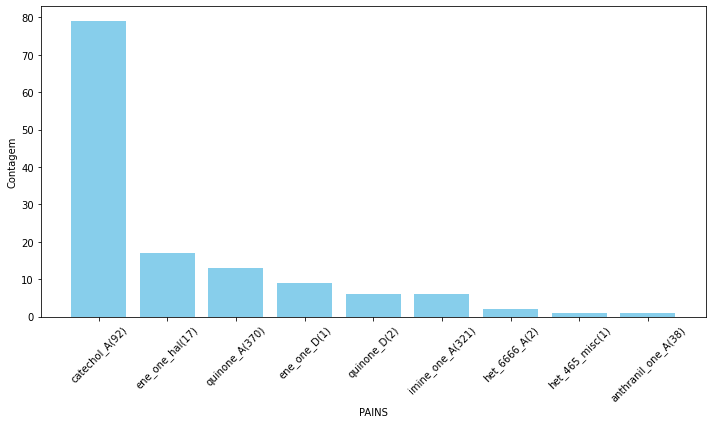

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter


# Vamos "achatar" (flatten) as listas na coluna PAINS_IDs
all_PAINS = [item for sublist in df_pains["PAINS_IDs"] for item in sublist]

# Contar as ocorrências
counts = Counter(all_PAINS)

# Converter a DataFrame para criar o barplot
counts_df = pd.DataFrame(counts.items(), columns=["String", "Count"]).sort_values(by="Count", ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(counts_df["String"], counts_df["Count"], color="skyblue")
plt.xlabel("PAINS")
plt.ylabel("Contagem")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Vemos que no nosso *dataset* de produto naturais, a subestrutura PAINS mais comum é o catecol A.

Vamos desenhar alguns dos nossos compostos usando nossa função `pains_highlight()` para destacar as subestruturas PAINS encontradas.

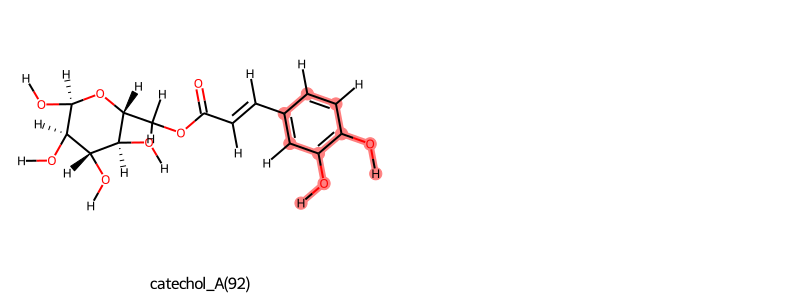

In [11]:
pains_highlight(df_pains.iloc[0]["Mol"])

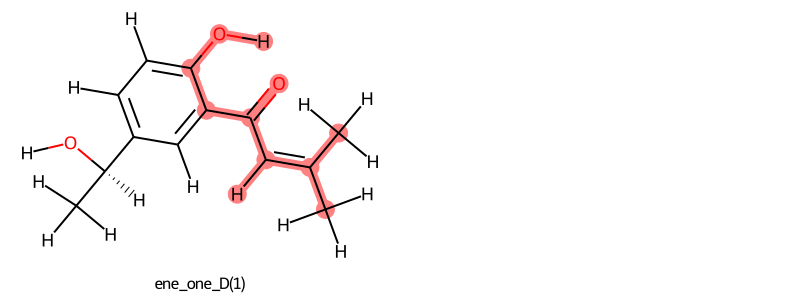

In [12]:
pains_highlight(df_pains.iloc[35]["Mol"])

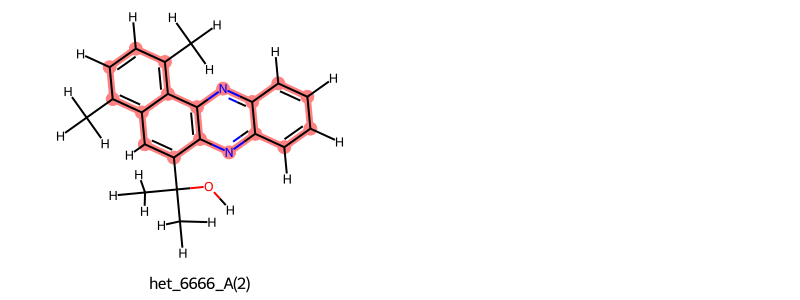

In [13]:
pains_highlight(df_pains.iloc[45]["Mol"])

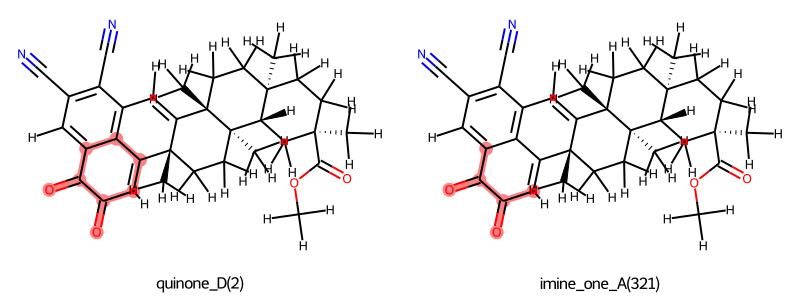

In [14]:
pains_highlight(df_pains.iloc[-1]["Mol"])

# Fontes consultadas

TeachOpenCADD T003 - [Molecular filtering: unwanted substructures](https://projects.volkamerlab.org/teachopencadd/talktorials/T003_compound_unwanted_substructures.html)

[Curating the PAINS filters](https://rdkit.blogspot.com/2015/08/curating-pains-filters.html)